In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sequencing_tools.viz_tools import okabeito_palette, color_encoder, simpsons_palette
from sequencing_tools.stats_tools import p_adjust
from scipy.special import ndtr
from collections import defaultdict
from sequencing_tools.fastq_tools import reverse_complement
from sequencing_tools.bam_tools import get_strand
import RNA
from multiprocessing import Pool
import random
import pysam
import glob
import re
#import genomeview
from pybedtools import BedTool
import mappy as mp
from plotting_utils import figure_path
from matplotlib import rcParams
from peak_utils import *
from tblout_parser import read_tbl

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [2]:
project_path = '/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map'
peak_path = project_path + '/bed_files/merged_bed/MACS2/annotated'
#peak_path = project_path + '/CLAM//BED_files/peaks/annotation'
peak_tsv = peak_path + '/unfragmented.tsv'
print(peak_tsv)
peak_df = load_peaks(peak_tsv)  \
    .assign(sense_gtype = lambda d: np.where(d.sense_gtype == ".", 'Unannotated', d.sense_gtype))\
    .assign(antisense_gtype = lambda d: np.where(d.antisense_gtype == ".", 'Unannotated', d.antisense_gtype)) \
    .sort_values('pileup', ascending=False)
peak_df.head()

/stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/bed_files/merged_bed/MACS2/annotated/unfragmented.tsv


,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,sense_gname,sense_gtype,strand,antisense_gname,antisense_gtype,pvalue,FDR,is_sense
0,chr1,28975111,28975251,unfragmented.fwd_peak_649,574990,10825.39258,57507.02344,57499.04688,11125.0,15,RNU11,snRNA,+,.,Unannotated,0.0,0.0,Sense
1,chr6,95156834,95156909,unfragmented.rvs_peak_24679,382188,7573.14697,38227.48047,38218.88672,9010.0,15,MTPAP,RBP,-,.,Unannotated,0.0,0.0,Sense
2,chr9,35657742,35658019,unfragmented.rvs_peak_28753,70213,1631.20764,7028.68262,7021.31055,1711.0,15,RMRP,Long RNA,-,.,Unannotated,0.0,0.0,Sense
3,chr14,20811226,20811574,unfragmented.rvs_peak_8125,50677,1165.14563,5075.10986,5067.79541,1193.0,15,RPPH1,Long RNA,-,.,Unannotated,0.0,0.0,Sense
48642,chr16,223472,223709,unfragmented.rvs_peak_10085,22611,576.96393,2267.85620,2261.10278,776.0,15,.,Unannotated,-,LSM11,RBP,0.0,0.0,Antisense


In [3]:
ce = color_encoder()
colors = simpsons_palette()
#colors.extend(['black','white'])
random.seed(12)
colors = random.sample(colors, k = len(peak_df.sense_gtype.unique()))
ce.fit(peak_df.sense_gtype, colors)
ce.encoder = {'Long RNA': '#370335',
     'RBP': '#91331F',
     'Repeats': '#197EC0',
     'Unannotated': '#46732E',
     'miRNA': '#FD7446',
     'misc RNA': '#FD8CC1',
     'tRF3':'black',
     'tRF5':'black',
     'piRNA': '#D5E4A2',
     'snRNA': '#8A9197',
     'snoRNA': '#FED439'}

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/stor/home/cdw2854/cfNA/plots/peak_utils.py:478: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0, 1e4)


Plotted:  /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_qc.pdf


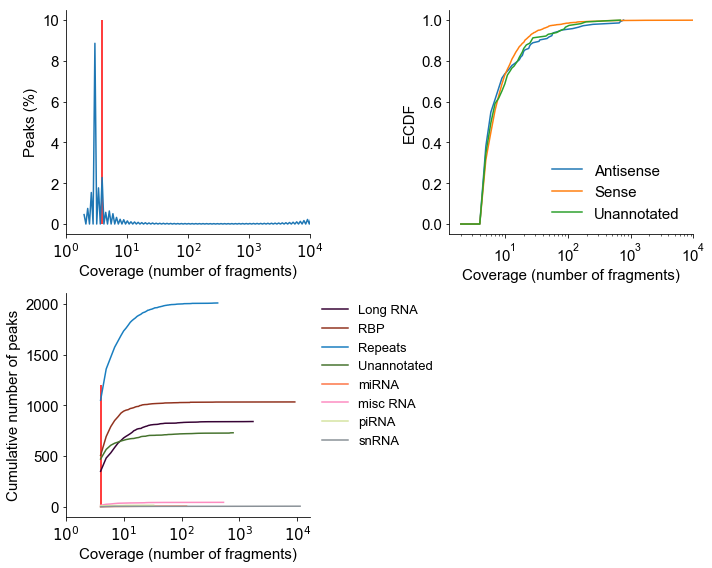

In [4]:
fig = plt.figure(figsize=(10,8))
cov_ax = fig.add_subplot(221)
number_ax = fig.add_subplot(223)
dist_cov_ax = fig.add_subplot(222)
#peak_annotation_ax = fig.add_subplot(224)

plot_peak_coverage(peak_df, cov_ax, log=True)
#plot_cov_density(peak_df, dist_cov_ax)
plot_peak_cum_cov(peak_df, dist_cov_ax)
plot_peak_number(peak_df, number_ax, ce)
#### add hepG2
#combined_peaks = pd.concat([peak_df.assign(annotation = 'K562'),
#                        hep_peak_df.assign(annotation = 'K562 + HepG2')])
#plot_peak_bar(peak_annotation_ax, combined_peaks)
fig.tight_layout()

figurename = figure_path + '/peak_qc.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [5]:
peak_df.sense_gtype.unique()

array(['snRNA', 'RBP', 'Long RNA', 'Unannotated', 'misc RNA', 'Repeats',
       'miRNA', 'piRNA', 'snoRNA'], dtype=object)

Saved: /stor/work/Lambowitz/cdw2854/cfNA/tgirt_map/figure/peak_figure.pdf


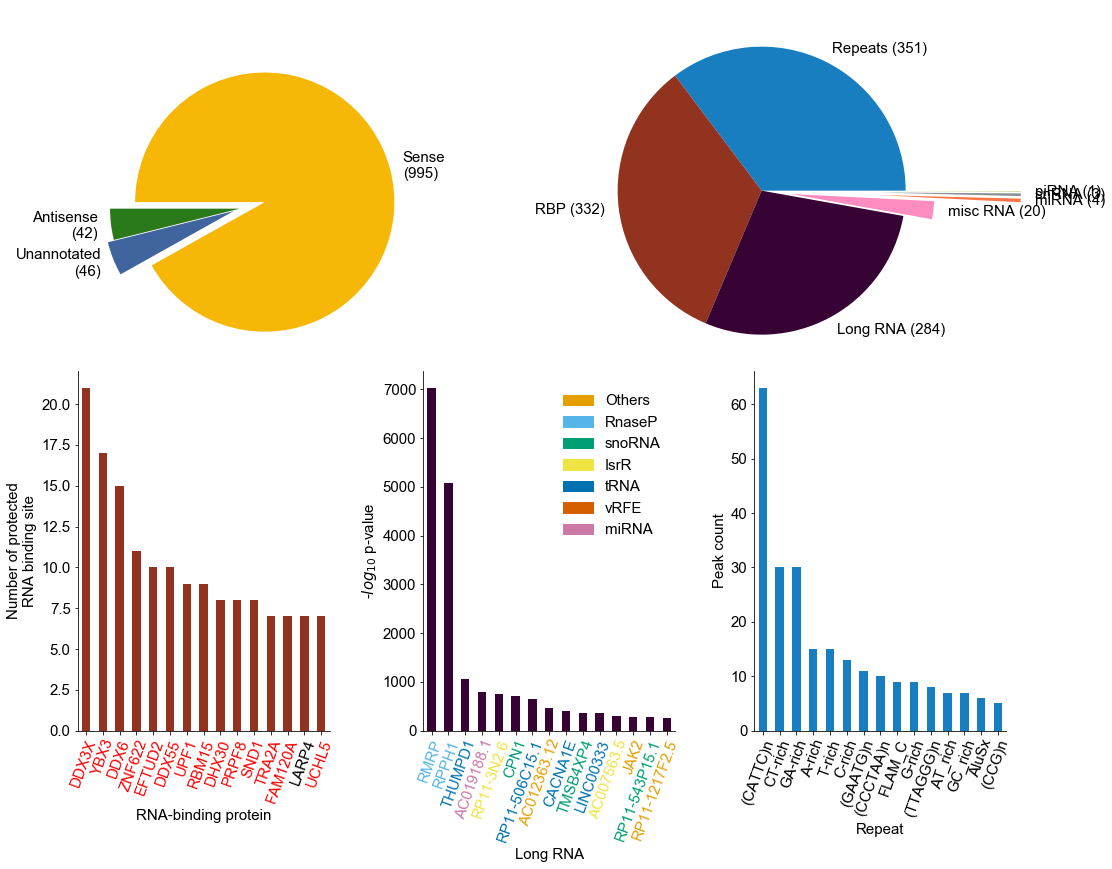

In [19]:
fig = plt.figure(figsize=(10,10))

strand_ax = fig.add_axes([-0.1, 0.5, 0.45, 0.45])
pie_ax = fig.add_axes([0.6, 0.5, 0.5, 0.5])
rbp_ax = fig.add_axes([-0.1, 0, 0.35, 0.5])
long_ax = fig.add_axes([0.38, 0, 0.35, 0.5])
misc_ax = fig.add_axes([0.84, 0, 0.35, 0.5])

top_n = 15
plot_peak_strand(peak_df, strand_ax)
sense_peaks = peak_df.query('is_sense == "Sense"')
plot_peak_pie(sense_peaks, pie_ax, ce)
plot_RNA(sense_peaks, misc_ax, ce, rnatype='Repeats', top_n = top_n)
rbp_df = plot_rbp(sense_peaks, rbp_ax, ce, top_n = top_n)
plot_long_RNA_peak(peak_df, long_ax, ce, top_n = top_n, y_val = 'log10p')
#l1 = mlines.Line2D([0.3,0.6],[0.9,0.955], color= 'black',
#                   figure = fig,  transform=fig.transFigure)
#l2 = mlines.Line2D([0.3,0.65],[0.58,0.51], color= 'black',
#                   figure = fig,  transform=fig.transFigure)
#fig.lines.extend([l1, l2])
figure_name = figure_path + '/peak_figure.pdf'
fig.savefig(figure_name, bbox_inches = 'tight')
print('Saved:', figure_name)

In [7]:
import RNA 

lr_peak = peak_df\
    .query('sense_gtype=="Long RNA"') \
    .query('pileup >= %i & sample_count >= %i'%(pileup_cutoff, sample_cutoff))\
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(mt = lambda d: d.seq.map(is_mt))  \
    .assign(shape = lambda d: d.seq.map(RNA.fold))\
    .assign(energy = lambda d: list(map(lambda x: x[1], d['shape'])))\
    .assign(shape = lambda d: list(map(lambda x: x[0], d['shape'])))\
    .assign(width = lambda d: d.end - d.start)\
    .sort_values('log10p', ascending=False)

In [8]:
cmscan_df = read_tbl(peak_path + '/unfragmented.Long_RNA.tblout') \
    .assign(peakname = lambda d: d['query name'].str.split('(', expand=True).iloc[:,0]\
                                   .str.replace('^RF[0-9]+','')\
                                   .str.strip(' '))\
    .assign(strand = lambda d: np.where(d.strand=="+", 0,1) )\
    .groupby('peakname', as_index=False)\
    .apply(lambda d: d.pipe(lambda d1: d1[d1.strand==d1.strand.min()]).pipe(lambda d1: d1[d1.score==d1.score.max()]))
cmscan_df.head()

,,E-value,accession,bias,description of target,gc,inc,mdl,mdl from,mdl to,pass,query name,score,seq from,seq to,strand,target name,trunc,peakname
0,274,.0 10.0,_24589(+) -,2 0.,5.5 ? -,5',,-,cm,67,-,RF00430 unfragmented.fwd_peak_,.52 0.,129,117,1,SNORA54,56,unfragmented.fwd_peak_
1,124,3.9,-,0.1,-,0.31,?,cm,1,501,3,unfragmented.fwd_peak_10067(+),6.5,20,110,0,rli47,3',unfragmented.fwd_peak_10067
2,288,1.2,-,0.0,-,0.39,?,cm,1,81,1,unfragmented.fwd_peak_10085(+),13.6,255,176,1,EBv-sisRNA-1,no,unfragmented.fwd_peak_10085
3,177,6.5,-,0.0,-,0.41,?,cm,1,80,1,unfragmented.fwd_peak_10086(+),12.1,105,184,0,SNORD39,no,unfragmented.fwd_peak_10086
4,93,8.1,-,0.0,-,0.68,?,cm,203,270,2,unfragmented.fwd_peak_10996(+),4.8,10,72,0,snoU89,5',unfragmented.fwd_peak_10996


In [9]:
cmscan_df.reset_index().filter(regex='name')

,query name,target name,peakname
0,RF00430 unfragmented.fwd_peak_,SNORA54,unfragmented.fwd_peak_
1,unfragmented.fwd_peak_10067(+),rli47,unfragmented.fwd_peak_10067
2,unfragmented.fwd_peak_10085(+),EBv-sisRNA-1,unfragmented.fwd_peak_10085
3,unfragmented.fwd_peak_10086(+),SNORD39,unfragmented.fwd_peak_10086
4,unfragmented.fwd_peak_10996(+),snoU89,unfragmented.fwd_peak_10996
5,unfragmented.fwd_peak_11015(+),snoU89,unfragmented.fwd_peak_11015
6,unfragmented.fwd_peak_1184(+) -,SNORD19B,unfragmented.fwd_peak_1184
7,unfragmented.fwd_peak_12345(+),Ms_AS-4,unfragmented.fwd_peak_12345
8,unfragmented.fwd_peak_12439(+),ACAT,unfragmented.fwd_peak_12439
9,unfragmented.fwd_peak_12994(+),suhB,unfragmented.fwd_peak_12994


In [10]:
lr_peak.merge(cmscan_df, on ='peakname', how='left')\
    .filter(['chrom','start','end', 'peakname','log10p', 'sense_gname','target name','strand_x'])\
    .nlargest(15,'log10p')

,chrom,start,end,peakname,log10p,sense_gname,target name,strand_x
0,chr9,35657742,35658019,unfragmented.rvs_peak_28753,7028.68262,RMRP,RNaseP_nuc,-
1,chr14,20811226,20811574,unfragmented.rvs_peak_8125,5075.10986,RPPH1,RNaseP_nuc,-
2,chr16,20733598,20733724,unfragmented.rvs_peak_10427,1052.66626,THUMPD1,tRNA,-
3,chr4,91759630,91760267,unfragmented.rvs_peak_21461,797.49237,AC019188.1,mir-74,-
4,chr7,63571927,63571997,unfragmented.rvs_peak_25997,745.29108,RP11-3N2.6,IsrR,-
5,chr10,101817586,101817662,unfragmented.rvs_peak_3849,715.03577,CPN1,TtnuHACA22,-
6,chr9,81357659,81357730,unfragmented.rvs_peak_28958,646.68506,RP11-506C15.1,tRNA,-
7,chr2,120972694,120972773,unfragmented.fwd_peak_16801,468.19608,AC012363.12,CrcZ,+
8,chr1,181391983,181392122,unfragmented.fwd_peak_2237,406.14514,CACNA1E,tRNA,+
9,chr9,131104873,131105059,unfragmented.fwd_peak_31554,359.48578,TMSB4XP4,snoR64a,+


In [11]:
lr_peak.query('width == 1751')

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width


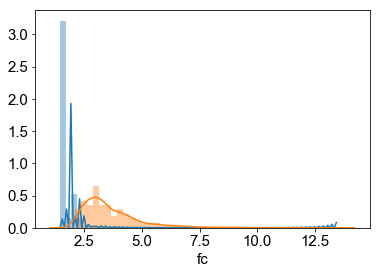

In [12]:
sns.distplot(peak_df.fc.transform(np.log2))
sns.distplot(peak_df.query('pileup >= 4 & sample_count >= 5').fc.transform(np.log2))

In [13]:
lr_peak.query('peakname=="unfragmented.fwd_peak_28467"')

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width


In [14]:
fold = lr_peak.nlargest(20,'log10p').pipe(lambda d: d[~d.sense_gname.str.contains('RMRP|RPPH1|AC019188.1|HIST')])
fold.head()

,chrom,start,end,peakname,score,fc,log10p,log10q,pileup,sample_count,...,antisense_gname,antisense_gtype,pvalue,FDR,is_sense,seq,mt,shape,energy,width
9,chr16,20733598,20733724,unfragmented.rvs_peak_10427,10462,276.62015,1052.66626,1046.26050,281.0,15,...,SFPQ,RBP,0.0,0.0,Sense,TAGAACTGCTAACTCATGCCACCATGTTTAATAACATGGCTTTCTC...,not_MT,.......(((((((.(((...(((((((....)))))))..........,-21.799999,126
13,chr7,63571927,63571997,unfragmented.rvs_peak_25997,7389,198.07874,745.29108,738.99146,200.0,15,...,RP11-165H4.1,Long RNA,0.0,0.0,Sense,AAGTAAGGTCAGCTAAATAAGCTATCTGGCCCATACCCCAAAAATG...,not_MT,..(((.((((((.((.......)).))))))..))).((((........,-9.500000,70
14,chr10,101817586,101817662,unfragmented.rvs_peak_3849,7087,192.81664,715.03577,708.77368,195.0,15,...,.,Unannotated,0.0,0.0,Sense,AGTTCACTGTAAAGCTAACCCAGCATTAACCTTTTAAGTTAAAGAC...,not_MT,..((((((((((.(((.....)))......((((......)))).....,-17.299999,76
15,chr9,81357659,81357730,unfragmented.rvs_peak_28958,6404,174.42755,646.68506,640.49841,176.0,15,...,.,Unannotated,0.0,0.0,Sense,AGAGTAAGGTCAGTTAAATAAGCTAACGGGCCCATACCCCGAAAAT...,not_MT,..(((((((..((.......((((((((((......)))..........,-11.300000,71
18,chr2,120972694,120972773,unfragmented.fwd_peak_16801,4619,133.52806,468.19608,461.92404,135.0,14,...,AC012363.4,Long RNA,0.0,0.0,Sense,ACTTTTAAAGAATTAGAGTTGTCTATTGGTCTTAGGAACCAAAAAC...,not_MT,(((((((........(((((((((((((((.......))))).......,-13.000000,79


In [15]:
import random
from collections import Counter
from scipy.stats import ranksums

es = []
bases = list('ACTG')
for w, seq in zip(fold.width, fold.seq):
    b = Counter(seq.upper())
    weights = [b[n] for n in bases]
    for i in range(20):
        random_seq = ''.join(random.choices(list('ACTG'), 
                                            k=w, weights=weights))
        s, e = RNA.fold(random_seq)
        es.append(e)

In [16]:
w, p = ranksums(es, fold.energy.values)

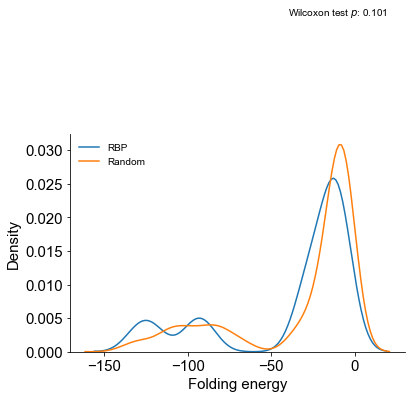

In [17]:
ax = plt.subplot()
sns.distplot(fold.energy, label = 'RBP', ax = ax, hist=False)
sns.distplot(es, label = 'Random', ax = ax, hist=False)
ax.text(-40,0.05, 'Wilcoxon test $p$: %.3f' %p)
ax.legend(frameon=False)
sns.despine()
ax.set_xlabel('Folding energy')
ax.set_ylabel('Density')
plt.savefig(figure_path + '/fold_energy.pdf', bbox_inches='tight')

In [18]:
colnames = rbp.columns.tolist()
colnames.extend(['tRNA_chrom','tRNA_start','tRNA_end','tRNA_name', 
                'tRNA_score','tRNA_strand', 'tRNA_type',
               'tRNA_id','distance'])

closest = BedTool().from_dataframe(rbp.sort_values(['chrom','start','end']))\
    .closest(b = '/stor/work/Lambowitz/ref/hg19/new_genes/tRNA.sorted.bed', d= True) \
    .to_dataframe(names = colnames) 

NameError: name 'rbp' is not defined

In [ ]:
'|'.join(closest.nlargest(20, 'log10p').query('distance < 100').sense_gname)

In [ ]:
RNA.fold(rbp.seq.values[2])

In [ ]:
sns.jointplot(peak_df.pileup.transform(np.log),
            peak_df.sample_count)

In [ ]:
','.join(rbp_df.head(15).index)

In [ ]:
peak_df\
    .query('pileup >= %i' %pileup_cutoff)\
    .to_csv(peak_path + '/peaks.tsv',sep='\t', index=False)

In [ ]:
ax = plt.subplot()
pdf = peak_df\
    .pipe(lambda d: d[~d.sense_gtype.str.contains('tRF')])\
    .query('pileup >= %i' %pileup_cutoff)\
    .assign(peak_width = lambda d: d.end-d.start)\
    .assign(log_pile = lambda d: d.pileup.transform(np.log10))

pdf.plot.scatter('peak_width','pileup', 
                  color = ce.transform(pdf.sense_gtype), ax = ax,
                 alpha = 0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ce.show_legend(ax = ax, bbox_to_anchor =(1,1), frameon=False)
sns.despine()

In [ ]:
ax = plt.subplot()

for gt, gd in peak_df\
            .query('pileup >= %i' %(pileup_cutoff))\
            .assign(peak_width = lambda d: (d.end-d.start))\
            .groupby('sense_gtype'):
    alpha = 1 if gt in ["Long RNA"] else 1
    sns.distplot(gd.peak_width, ax = ax, kde_kws={'alpha':alpha},
                label = gt, color = ce.encoder[gt],
                hist=False)
lgd = ax.legend(frameon=False)
for lh in lgd.legendHandles: 
    lh.set_alpha(1)
ax.set_ylabel('Density')
ax.set_xlabel('Peak width ($log_{10}$ nt)')

x_range = np.arange(1,500, 50)
ax.set_xlim(x_range.min(), x_range.max())
ax.set_xticks(x_range)
for xt, x in zip(ax.get_xticklabels(), x_range):
    xt.set_text(r'$10^{%s}$' %(x))

In [ ]:
lR_peak = peak_df[peak_df.sense_gtype.str.contains('Long RNA')] \
    .sort_values('log10p', ascending=False) 
lR_peak.head(20)

In [ ]:
anti_peaks.antisense_gtype.unique()

In [ ]:
anti_peaks = peak_df.query('is_sense == "Antisense"')\
    .pipe(lambda d: d[~d.antisense_gtype.str.contains('tRF')])

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0.1,0.4,0.8])
plot_peak_pie(anti_peaks, ax, ce, gtype='antisense_gtype')
ax = fig.add_axes([0.7, 0, 0.4, 1])
anti_plot = anti_peaks.nlargest(15, 'log10p')
anti_plot.plot\
    .bar('antisense_gname', 'log10p', 
         color = ce.transform(anti_plot\
                               .antisense_gtype),
        ax = ax)
ax.legend().set_visible(False)
ax.set_xlabel('RNA type')
ax.set_ylabel('-$log_{10}$ p-value')
sns.despine()
fig.tight_layout()
figurename = figure_path + '/peak_anti.pdf'
fig.savefig(figurename, bbox_inches = 'tight')
print('Plotted: ', figurename)

In [ ]:
fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
fa.fetch('chr12',22158771,22158870)

In [ ]:
columns = peak_df.columns
columns = np.append(columns,['intron_chrom','intron_start','intron_end',
               'intron_gene','intron_score','intron_strand'])
intron_df = BedTool()\
    .from_dataframe(peak_df )\
    .intersect('/stor/work/Lambowitz/ref/hg19/genome/independent_intron.bed', 
               f= 0.8,F=0.8,wb=True)\
    .to_dataframe(names = columns)
intron_df.shape

In [ ]:
intron_df \
    .query('pileup >= 5' )

In [ ]:
ss_dinucleotide = defaultdict(int)
ss_dinucleotide_seq = defaultdict(list)
seqs = []
fa = pysam.Fastafile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
def fetch_seq(chrom, start, end, strand):
    intron_seq = fa.fetch(chrom, start - 1, end)
    intron_seq = intron_seq if strand == "+" else reverse_complement(intron_seq)
    return intron_seq
    
    

intron_df = intron_df.query('pileup >=3') \
    .assign(seq = lambda d: list(map(fetch_seq, d.chrom, d.start, d.end, d.strand))) \
    .assign(dinucleotide = lambda d: d.seq.str.slice(0,2) + ':' + (d.seq + 'N').str.slice(-3,-1))
intron_df.head()

In [ ]:
tablename = figure_path + '/intron_table.csv'
intron_df \
    .filter(regex='chrom|start|end|log10|pileup|intron_gene|seq') \
    .sort_values('pileup', ascending=False)\
    .to_csv(tablename, index=False)
print('Written: ', tablename)

In [ ]:
intron_df.query('pileup >= %i' %pileup_cutoff) \
    .assign(length = lambda d: d.end - d.start) \
    .describe()

In [ ]:
%load_ext autoreload
%autoreload 2
import mygene as mg
import gseapy as gsp
mgi = mg.MyGeneInfo()

glist = intron_df.query('pileup >= %i' %pileup_cutoff) \
    .filter(['pileup','gid']) \
    .assign(ensg = lambda d: d.gid.str.extract('(ENSG[0-9]+)')) \
    .assign(symbol = lambda d: list(map(lambda x: x['symbol'], mgi.getgenes(d.ensg))))

In [ ]:
glist

In [ ]:
%tb
rnk = glist\
    .filter(['symbol','pileup']) \
    .pipe(lambda d: d[~d.symbol.str.contains('^AC')])\
    .rename(columns={'symbol':'gene_name'})
#res = gsp.prerank(rnk = rnk, gene_sets='/stor/work/Lambowitz/ref/gene_sets/c2.all.v6.2.symbols.gmt')
print('\n'.join(rnk.gene_name.tolist()))



In [ ]:
peaks\
    .query('merged_type == "miRNA"')\
    .filter(regex='log10p|picked_RNA_sense')\
    .set_index('picked_RNA_sense')\
    .nlargest(10, 'log10p')\
    .plot.bar() 

In [ ]:
peaks.pipe(lambda d: d[d.picked_RNA_sense.str.contains("CGGA")])

In [ ]:
peaks\
    .assign(anti_merged_type = lambda d: d.picked_type_anti.map(merge_type)) \
    .query('merged_type == "Repeats" | (anti_merged_type == "Repeats" & is_sense != "Sense")')

In [ ]:
peaks\
    .query('merged_type=="RBP"')\
    .pipe(lambda d: d[~d.gtype.str.contains(lrna_regex)])

In [ ]:
import gseapy as gsp

In [ ]:
res = gsp.prerank(rnk = rbp_df.sort_values(0,ascending=False),
           gene_sets = 'KEGG_2016')

In [ ]:
res.res2d

In [ ]:
aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
aln = aligner.map(fa.fetch('chr17',33981908,33982067))

In [ ]:
print(next(aln))

In [ ]:
def check_MT(peaks, return_column=False):
    mt = 0
    aligner = mp.Aligner('/stor/work/Lambowitz/ref/hg19/genome/chrM.minimap2_idx', preset='sr')
    fa = pysam.FastaFile('/stor/work/Lambowitz/ref/hg19/genome/hg19_genome.fa')
    mts = []
    for peak_count, row in peaks.reset_index().iterrows():
        seq = fa.fetch(row['chrom'], row['start'], row['end'])
        seq = seq if row['strand'] == "+" else reverse_complement(seq)
    
        alns = aligner.map(seq)
        try:
            aln = next(alns)
            mt += 1
            mts.append('MT')
            #print(aln.cigar_str)
        except StopIteration:
            #print(row)
            mts.append('no')
            pass


    print('%i seq: %i in MT' %(peak_count, mt))
    if return_column:
        return mts

In [ ]:
anti = peak_df.query('pileup >= 5').query('is_sense == "Unannotated"')
anti['MT'] = check_MT(anti, return_column=True)

In [ ]:
peak_df.query("sense_gtype == 'tRF3'")